<a href="https://colab.research.google.com/github/afvallejo/SIG/blob/master/Differential_expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages 

In [0]:
#@title
%%time
!pip install MulticoreTSNE scanpy[louvain] MulticoreTSNE anndata2ri scvelo leidenalg bbknn rpy2==3.3.2 umap-learn==0.3.9 pandas==0.25.3

In [0]:
!pip install diffxpy

In [0]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
%load_ext rpy2.ipython

In [0]:
%%R
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install(c("MAST", "scater"))


# set up WD

 # load Libraries

In [46]:
import scanpy as sc

# numpy et al.
import numpy as np
import scipy as sp
import pandas as pd
import gc
import bbknn

# R integration
from rpy2.robjects.packages import importr

from rpy2.robjects.vectors import StrVector, FloatVector, ListVector
import rpy2.robjects as ro
import anndata2ri

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import seaborn as sb
import re
import scipy as sp
import datetime, time
sc.settings.verbosity = 3               # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.logging.print_version_and_date()


import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri, numpy2ri, r



# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython


scanpy==1.4.6 anndata==0.7.1 umap==0.3.9 numpy==1.18.3 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.2 louvain==0.6.1
Running Scanpy 1.4.6, on 2020-04-29 09:29.
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Download the data

In [5]:
!gdown --id 13Wd7kxAn7vHcNsbEZE5H--3Du9dPkVza

Downloading...
From: https://drive.google.com/uc?id=13Wd7kxAn7vHcNsbEZE5H--3Du9dPkVza
To: /content/PBMC_IFN_singler.h5ad
1.78GB [00:16, 107MB/s]


In [47]:
adata=sc.read('PBMC_IFN_singler.h5ad')
adata

AnnData object with n_obs × n_vars = 13836 × 14053 
    obs: 'n_genes', 'n_counts', 'orig_ident', 'stim', 'cluster', 'Donor', 'sample', 'log_counts', 'size_factors', 'louvain', 'leiden', 'leiden_r1', 'leiden_r0.5', 'leiden_r0.4', 'leiden_r0.3', 'leiden_r0.2', 'predicted1'
    var: 'gene.mean', 'gene.dispersion', 'gene.dispersion.scaled', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Donor_colors', 'about_readme', 'about_short_title', 'about_title', 'cell_type_prediction', 'cluster_colors', 'leiden', 'leiden_colors', 'leiden_r0.5_colors', 'leiden_r1_colors', 'louvain', 'louvain_colors', 'marker_avg_logFC', 'marker_cluster', 'marker_gene', 'marker_p_val_adj', 'neighbors', 'pca', 'predicted1_colors', 'stim_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

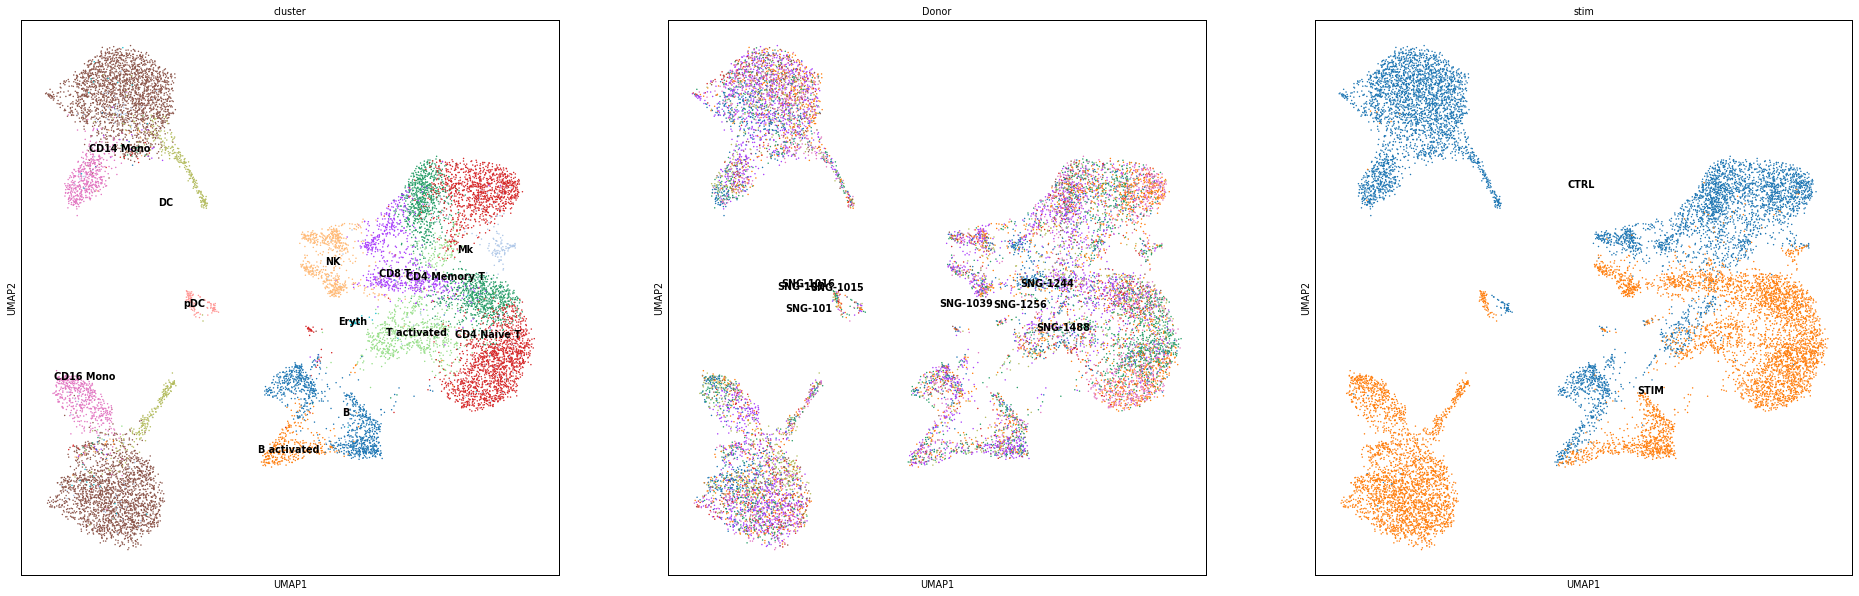

In [48]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(10,10)

sc.pl.umap(adata,color=['cluster', 'Donor','stim' ],legend_loc='on data')

In [0]:
marker_genes = ['CD79A', 'MS4A1', 'CD8A', 'CD8B', 'GNLY', 'NKG7','IL7R','LYZ', 'CD14','FCGR3A', 'MS4A7', 'FCER1A', 'CST3',
                'PPBP','LGALS3', 'S100A8', 'KLRB1', 'HLA-DRA']

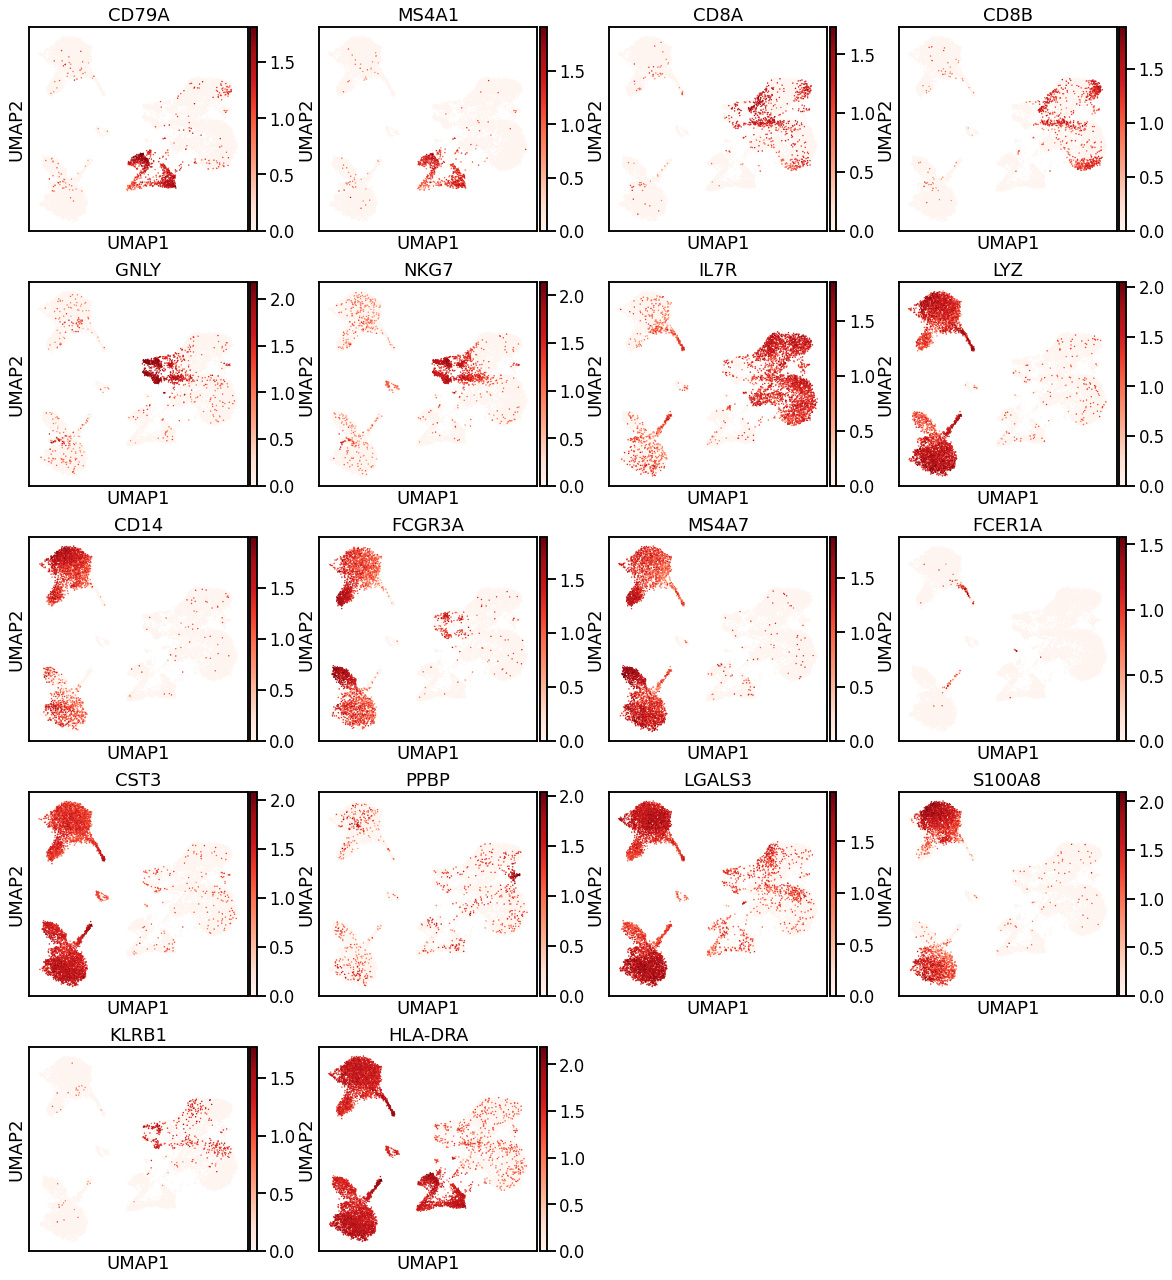

In [14]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(4,4) #rescale figures
sc.pl.umap(adata=adata, color=marker_genes,color_map='Reds', use_raw=True)

# Differential expression analysis

## t-test

In [57]:
sc.tl.rank_genes_groups(adata, 'cluster', method='t-test')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [60]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).head(5)

,B_n,B_p,B_l,B activated_n,B activated_p,B activated_l,CD4 Memory T_n,CD4 Memory T_p,CD4 Memory T_l,CD4 Naive T_n,CD4 Naive T_p,CD4 Naive T_l,CD8 T_n,CD8 T_p,CD8 T_l,CD14 Mono_n,CD14 Mono_p,CD14 Mono_l,CD16 Mono_n,CD16 Mono_p,CD16 Mono_l,DC_n,DC_p,DC_l,Eryth_n,Eryth_p,Eryth_l,Mk_n,Mk_p,Mk_l,NK_n,NK_p,NK_l,T activated_n,T activated_p,T activated_l,pDC_n,pDC_p,pDC_l
0,CD74,0.000000e+00,1.576232,HLA-DRA,2.892264e-180,1.383528,RPS18,0.0,0.459782,GIMAP7,0.0,2.264954,CCL5,2.706056e-258,3.910575,C15orf48,0.0,3.615182,FCGR3A,0.0,3.893783,HLA-DRA,0.000000e+00,1.837501,HBB,3.508283e-56,6.607602,PPBP,2.564140e-112,5.717991,NKG7,0.000000e+00,5.094809,BTG1,3.279960e-193,0.990895,SEC61B,1.978046e-90,2.124029
1,HLA-DRA,0.000000e+00,1.610325,HSP90AB1,8.359845e-138,1.453526,RPL13A,0.0,0.431953,CCR7,0.0,2.254055,NKG7,1.776471e-133,3.490626,TYROBP,0.0,3.205741,MS4A7,0.0,3.385268,HLA-DRB1,0.000000e+00,1.913575,HBA2,5.853355e-50,8.637030,PF4,5.668209e-67,6.776952,GNLY,0.000000e+00,5.992694,EIF1,1.544065e-124,0.357819,CD74,3.952097e-95,1.116504
2,CD79A,2.190111e-288,5.913090,HLA-DRB1,9.635222e-131,1.419981,RPS3,0.0,0.468513,RPS18,0.0,0.559991,CXCR4,1.392880e-113,1.194540,FCER1G,0.0,3.243019,TYROBP,0.0,1.958223,HLA-DPB1,0.000000e+00,2.280002,HBA1,5.927270e-46,9.293949,GNG11,1.735575e-65,6.222188,GZMB,3.863317e-262,5.443612,SOD1,1.313198e-106,1.483180,TSPAN13,1.062037e-56,7.121320
3,PTMA,1.505770e-280,0.626884,RAN,1.421281e-109,1.624754,RPL3,0.0,0.585738,RPL13,0.0,0.502994,CD3D,2.383217e-108,1.888103,CD63,0.0,2.836600,FCER1G,0.0,1.980979,HLA-DPA1,9.881313e-324,2.207992,ALAS2,1.248984e-19,11.654982,SDPR,1.040011e-50,6.693445,APOBEC3G,1.189938e-174,2.803013,SRSF2,7.083474e-98,2.298689,GZMB,8.075536e-51,4.272273
4,HLA-DPA1,1.473545e-224,1.705236,NPM1,3.118116e-110,1.472380,RPS4X,0.0,0.465303,RPL32,0.0,0.541527,PTMA,6.430111e-113,0.481199,ANXA5,0.0,2.771819,TIMP1,0.0,1.961315,ANXA2,0.000000e+00,1.546319,SNCA,9.864167e-17,5.901452,CCL5,1.179804e-36,2.409694,CCL5,4.085618e-143,3.525513,CACYBP,7.180300e-94,1.958472,TXN,5.276760e-52,2.046017


# Subset

In [40]:
subset=adata[adata.obs['cluster'].isin(['CD14 Mono'])]
subset

View of AnnData object with n_obs × n_vars = 4225 × 14053 
    obs: 'n_genes', 'n_counts', 'orig_ident', 'stim', 'cluster', 'Donor', 'sample', 'log_counts', 'size_factors', 'louvain', 'leiden', 'leiden_r1', 'leiden_r0.5', 'leiden_r0.4', 'leiden_r0.3', 'leiden_r0.2', 'predicted1'
    var: 'gene.mean', 'gene.dispersion', 'gene.dispersion.scaled', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Donor_colors', 'about_readme', 'about_short_title', 'about_title', 'cell_type_prediction', 'cluster_colors', 'leiden', 'leiden_colors', 'leiden_r0.5_colors', 'leiden_r1_colors', 'louvain', 'louvain_colors', 'marker_avg_logFC', 'marker_cluster', 'marker_gene', 'marker_p_val_adj', 'neighbors', 'pca', 'predicted1_colors', 'stim_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [0]:
sc.pp.neighbors(adata, n_pcs=30,n_neighbors=30,random_state=42)

sc.tl.louvain(subset, resolution = 0.5)
sc.tl.leiden(subset, resolution = 0.5)
sc.tl.umap(subset)

sc.pl.umap(subset, color = ['cluster', 'Donor','stim'])

In [44]:
sc.tl.rank_genes_groups(subset, groupby='stim', 
                        groups= ['STIM'], reference='CTRL', rankby_abs=True)

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


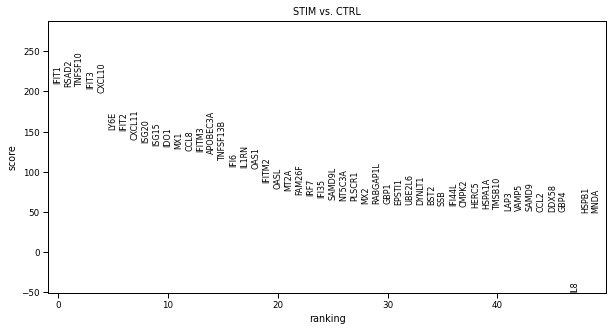

In [9]:
pl.rcParams['figure.figsize']=(10,5)
sc.pl.rank_genes_groups(subset, size=10, n_genes=50)

In [49]:
markers=pd.DataFrame(subset.uns['rank_genes_groups']['names']).head(30)
markers

,STIM
0,IFIT1
1,RSAD2
2,TNFSF10
3,IFIT3
4,CXCL10
5,LY6E
6,IFIT2
7,CXCL11
8,ISG20
9,ISG15


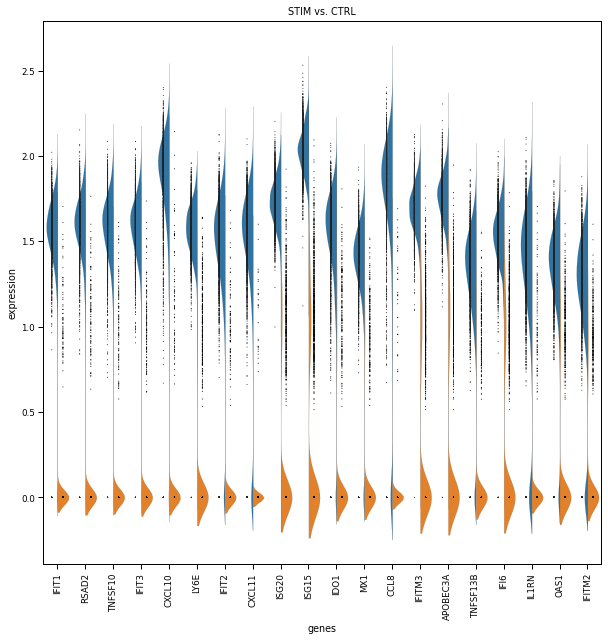

In [50]:
pl.rcParams['lines.linewidth'] = 0.1
sc.pl.rank_genes_groups_violin(subset,  n_genes=20, jitter=False)

# Difxpy

## T-test

In [0]:
import diffxpy.api as de

In [0]:
test_tt = de.test.t_test(data=subset,grouping="stim")

In [29]:
test_tt.summary().iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
0,AL627309.1,6.937996e-01,7.767017e-01,0.000000,-0.016918,False,False
1,RP11-206L10.2,3.173139e-01,4.240026e-01,0.000000,-0.014246,False,False
2,LINC00115,5.685090e-01,6.710489e-01,0.000000,-0.024263,False,False
3,NOC2L,2.817213e-07,1.667999e-06,0.000000,-0.184905,False,False
4,KLHL17,2.527621e-02,6.042784e-02,0.000000,-0.021789,False,False
5,PLEKHN1,1.167289e-03,4.051756e-03,1070.677266,0.043217,False,False
6,HES4,3.317008e-313,3.697148e-311,1074.209917,0.363601,False,False
7,ISG15,0.000000e+00,0.000000e+00,1074.220488,0.115646,False,False
8,AGRN,5.571586e-02,1.171192e-01,1068.836483,0.003029,False,False
9,C1orf159,1.987036e-01,3.139799e-01,0.000000,-0.045430,False,False


In [40]:
DEG=test_tt.gene_ids[1:10]
DEG

array(['RP11-206L10.2', 'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'HES4',
       'ISG15', 'AGRN', 'C1orf159'], dtype=object)

In [0]:
DEG=["HES4","ISG15"]

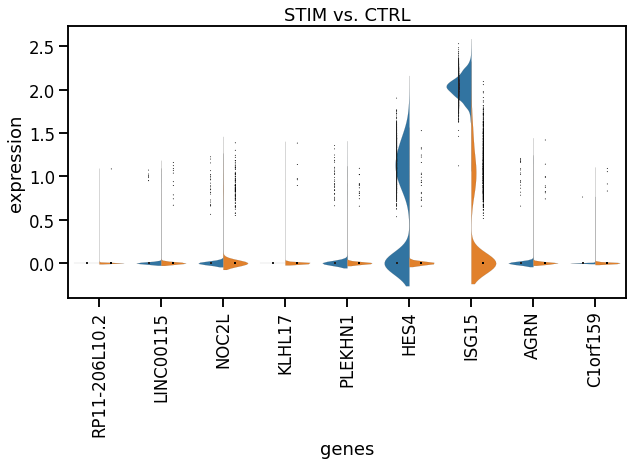

In [41]:
pl.rcParams['lines.linewidth'] = 0.1
sc.pl.rank_genes_groups_violin(subset, gene_names=DEG,  jitter=False)

# MAST

In [0]:
#Create new Anndata object for use in MAST with non-batch corrected data as before
adata_test = subset.copy()
adata_test.X = subset.raw.X
adata_test.obs['n_genes'] = (adata_test.X > 0).sum(1) # recompute number of genes expressed per cell

In [13]:
adata_test.shape

(4225, 14053)

In [14]:
%%R -i adata_test 
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(MAST))

adata_test<-logNormCounts(adata_test)
sca = SceToSingleCellAssay(adata_test)




/usr/local/lib/python3.6/dist-packages/anndata2ri/py2r.py:37: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  warn(str(e), NotConvertedWarning)
R[write to console]: `fData` has no primerid.  I'll make something up.

R[write to console]: `cData` has no wellKey.  I'll make something up.

R[write to console]: Assuming data assay in position 3, with name logcounts is log-transformed.



In [15]:
%%time
%%R
colData(sca)$n_genes = scale(colData(sca)$n_genes)

#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca))
print("")
sca_filt = sca[rowSums(assay(sca)) != 0, ]
print("Dimensions after subsetting:")
print(dim(sca_filt))

#Define & run hurdle model 
zlmCond_CTR <- zlm(formula = ~ stim + n_genes, sca=sca_filt)

[1] "Dimensions before subsetting:"
[1] 14053  4225
[1] ""
[1] "Dimensions after subsetting:"
[1] 13133  4225


R[write to console]: 
Done!



In [18]:
%%time
%%R -o IFN_de
options(Ncpus = 4)
summaryCond_CTR <- summary(zlmCond_CTR, doLRT='stimSTIM')
summaryDt_CTR <- summaryCond_CTR$datatable

result_CTR <- merge(summaryDt_CTR[contrast=='stimSTIM' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_CTR[contrast=='stimSTIM' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_CTR[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
IFN_de = result_CTR[result_CTR$FDR<0.01,, drop=F]
IFN_de = IFN_de[order(IFN_de$FDR),]

R[write to console]: Combining coefficients and standard errors

R[write to console]: Calculating log-fold changes

R[write to console]: Calculating likelihood ratio tests

R[write to console]: Refitting on reduced model...

R[write to console]: 
Done!



CPU times: user 7min 12s, sys: 31 s, total: 7min 43s
Wall time: 7min 42s


In [19]:
print(IFN_de.shape)
IFN_de[:20]

(4014, 4)


,primerid,Pr(>Chisq),coef,FDR
1,APOBEC3A,0.0,1.992692,0.0
2,BST2,0.0,1.068617,0.0
3,CCL2,0.0,1.303774,0.0
4,CCL8,0.0,2.301668,0.0
5,CD14,0.0,-1.070186,0.0
6,CD38,0.0,0.708758,0.0
7,CLEC5A,0.0,-0.881433,0.0
8,CMPK2,0.0,1.044194,0.0
9,CXCL10,0.0,2.508972,0.0
10,CXCL11,0.0,1.993648,0.0


In [42]:
DEG=IFN_de['primerid'][1:10]

2       BST2
3       CCL2
4       CCL8
5       CD14
6       CD38
7     CLEC5A
8      CMPK2
9     CXCL10
10    CXCL11
Name: primerid, dtype: object

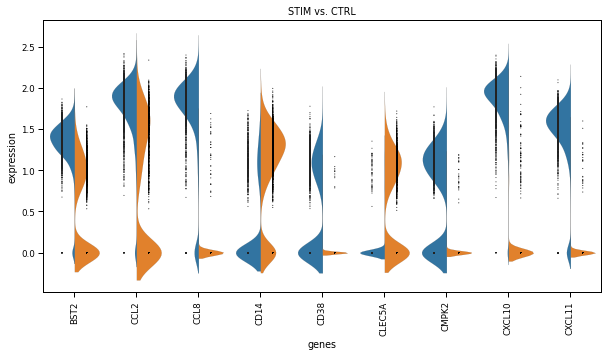

In [45]:
pl.rcParams['lines.linewidth'] = 0.1
sc.pl.rank_genes_groups_violin(subset, gene_names=DEG,  jitter=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


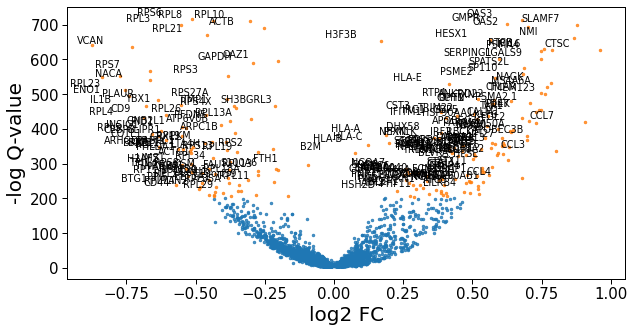

In [21]:
#Volcano plot of results
IFN_de['-logQ'] = -np.log(IFN_de['FDR'])
lowqval_de = IFN_de.loc[IFN_de['-logQ'] > 200]
other_de = IFN_de.loc[IFN_de['-logQ'] < 200]

fig, ax = pl.subplots()
sb.regplot(other_de['coef'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
sb.regplot(lowqval_de['coef'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
ax.set_xlabel("log2 FC", fontsize=20)
ax.set_ylabel("-log Q-value", fontsize=20)
ax.tick_params(labelsize=15)

# Label names and positions
x = [i-0.2 for i in lowqval_de['coef']]
y = [i+10 for i in lowqval_de['-logQ']]
labels = lowqval_de['primerid']

# Show only some labels to avoid overcrowding the figure
to_remove = np.where([i < 230 for i in y])[0]
labels = ["" if i in to_remove else lab for i,lab in enumerate(labels) ]

#Move up two labels
y = [y[i]+10 if txt == 'Krt8' else y[i] for i,txt in enumerate(labels)]
y = [y[i]+20 if txt == 'Cd9' else y[i] for i,txt in enumerate(labels)]

#Move down one label
y = [y[i]-20 if txt == 'Phgr1' else y[i] for i,txt in enumerate(labels)]

for i,txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
pl.show()

In [0]:
IFN_de.to_csv("DEG_allcells_CTR_vs_IFN.csv")

In [25]:
IFN_de['primerid']

1       APOBEC3A
2           BST2
3           CCL2
4           CCL8
5           CD14
          ...   
4010      HMG20B
4011     DNAJC21
4012     FAM135A
4013      TXNRD2
4014        RGL2
Name: primerid, Length: 4014, dtype: object